# Proxy

In [1]:
# import library
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import copy

Allostery:
<div>
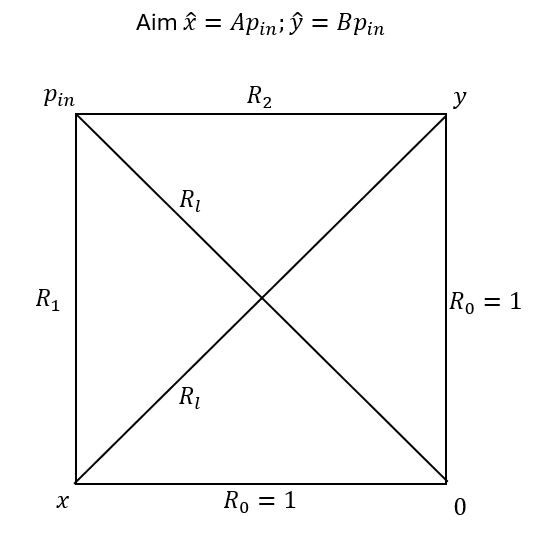
</div>


In [2]:
## Classes

class Variabs():
    def __init__(self, task_type, alpha, gamma):
        super(Variabs, self).__init__()
        self.task_type = task_type
        self.alpha = alpha
        self.gamma = gamma

class Syms():
    def __init__(self, variabs):
        super(Syms, self).__init__()
        if variabs.task_type == 'Allostery':
            self.x, self.y, self.R1, self.R2, self.Rl, self.p = sp.symbols('x, y, R1, R2, Rl, p')    
        elif variabs.task_type == 'Regression':
            self.x, self.R1, self.R2, self.Rl, self.p1, self.p2 = sp.symbols('x, R1, R2, Rl, p1, p2') 

class State():
    def __init__(self, syms, variabs, supress_prints, bc_noise):
        super(State, self).__init__()
        self.syms = syms
        self.variabs = variabs
        
        # self.R_in_t = [np.array([2.59272486, 5.18544973])]
        self.R_in_t = [np.array([1.,1.])]
        self.out_in_t = []
        self.loss_in_t = []
        self.t = 0
        
        if self.variabs.task_type == 'Allostery':
            self.out_clamped_in_t = [np.array([0.5,0.5])]
            self.p_in_t = [1]
            self.loss_fn = loss_fn_allostery
        elif self.variabs.task_type == 'Regression':
            self.out_clamped_in_t = [np.array([0.5])]
            # self.p_in_t = [np.array([0.5, 1.5])]
            self.p_in_t = [np.array([1, 1])]
            self.p_drawn_in_t = []
            self.desired_in_t = []
            self.loss_fn = loss_fn_regression
            
        self.supress_prints = supress_prints
        self.bc_noise=bc_noise
        
    def assign_P(self, syms):
        if self.variabs.task_type == 'Allostery':
            self.P = (syms.p-syms.x)**2/syms.R1 + (syms.p-syms.y)**2/syms.R2 + syms.x**2 + syms.y**2 + \
                     syms.p**2/syms.Rl + (syms.x-syms.y)**2/syms.Rl 
        elif self.variabs.task_type == 'Regression':
            self.P = (syms.p1-syms.x)**2/syms.R1 + (syms.p2-syms.x)**2/syms.R2 + syms.p1**2 + syms.p2**2 + \
                     syms.x**2/syms.Rl + (syms.p1-syms.p2)**2/syms.Rl
            
    def solve_pressure(self, syms):        
        if self.variabs.task_type == 'Allostery':
            dPdx = self.P.diff(syms.x)
            dPdy = self.P.diff(syms.y)
            sols = sp.solve([dPdx,dPdy],[syms.x,syms.y])
            self.x = sols[syms.x]
            self.y = sols[syms.y]
        elif self.variabs.task_type == 'Regression':
            dPdx = self.P.diff(syms.x)
            sols = sp.solve([dPdx],[syms.x])
            self.x = sols[syms.x]
    
    def calc_output(self, syms):
        if self.variabs.task_type == 'Allostery':
            # substitute the last resistances and initial input pressure in theoretical expression for pressure at output
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0],syms.R2:self.R_in_t[-1][1],syms.p:self.p_in_t[0],
                                 syms.Rl:2**(1/2)})
            y_nxt = self.y.subs({syms.R1:self.R_in_t[-1][0],syms.R2:self.R_in_t[-1][1],syms.p:self.p_in_t[0],
                                 syms.Rl:2**(1/2)})
            self.output = np.array([x_nxt, y_nxt])
        elif self.variabs.task_type == 'Regression':
            # substitute the last resistances and initial input pressure in theoretical expression for pressure at output
#             x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0],syms.R2:self.R_in_t[-1][1],syms.p1:self.p_in_t[-1][0],
#                                  syms.p2:self.p_in_t[-1][1], syms.Rl:2**(1/2)})
#             x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0],syms.R2:self.R_in_t[-1][1],syms.p1:self.p_in_t[0][0],
#                                  syms.p2:self.p_in_t[0][1], syms.Rl:2**(1/2)})
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0],syms.R2:self.R_in_t[-1][1],syms.p1:self.p_drawn[0],
                                 syms.p2:self.p_drawn[1], syms.Rl:2**(1/2)})
            self.output = x_nxt
        if self.supress_prints:
            pass
        else:
            print('output=', self.output)
        self.out_in_t.append(self.output)
    
    def calc_loss(self, desired, output_prev=0, desired_prev=0):
        if self.variabs.task_type=='Allostery':
            self.loss = self.loss_fn(self.output, desired)
        elif self.variabs.task_type=='Regression':
            self.loss = self.loss_fn(self.output, output_prev, desired, desired_prev)
        self.loss_in_t.append(self.loss)
        
    def update_pressure(self):
        self.t += 1
        loss = self.loss_in_t[-1]
        p = self.p_in_t[-1]
        pert = np.random.normal(size=np.size(p))
        if self.variabs.task_type == 'Allostery':
            # p_nxt = p - np.dot(state.variabs.alpha, loss) * self.t
            # p_nxt = p - np.dot(2*(1-np.e**-(state.variabs.alpha*self.t)), loss)
            # p_nxt = p - np.dot(self.variabs.alpha, loss*(1+self.bc_noise*pert))
            # p_nxt = p - np.dot(self.variabs.alpha, loss)       
            p_nxt = p - np.dot(self.variabs.alpha, loss+self.bc_noise*pert)
        elif self.variabs.task_type == 'Regression':
            p_drawn = self.p_drawn_in_t[-1]
            p_prev = self.p_drawn_in_t[-2]
            p_nxt = p - np.dot(self.variabs.alpha, np.dot(p_drawn-p_prev, loss[0]-loss[1]))
            print('the dot for p', np.dot(self.variabs.alpha, np.dot(p_drawn-p_prev, loss[0]-loss[1])))
        if self.supress_prints:
            pass
        else:
            print('loss=', loss)
            print('time=', self.t)
            print('p_nxt=', p_nxt)
        self.p_in_t.append(p_nxt)
        
    def update_BCs(self, desired):
        loss = self.loss_in_t[-1]
        pert = np.random.normal(size=np.size(self.output))
        out_clamped = self.out_clamped_in_t[-1]
        if self.variabs.task_type=='Allostery':
            # self.output = self.out_in_t[-1] + 2*(1-np.e**-(state.variabs.alpha*self.t)) * self.loss_in_t[-1]
            # self.output = self.out_clamped_in_t[-1] + self.variabs.alpha * self.loss_in_t[-1] * (1+self.bc_noise*pert)
            # self.output = self.out_clamped_in_t[-1]
            # self.output = np.array([desired])
            self.output = out_clamped + self.variabs.alpha * (loss + self.bc_noise*pert)
        elif self.variabs.task_type=='Regression':
            self.output = out_clamped + self.variabs.alpha * (loss[0]-loss[1])
        self.out_clamped_in_t.append(self.output)           
        if self.supress_prints:
            pass
        else:
            print('clamped output', self.output)
    
    def update_Rs(self):
        # R_nxt = R_in_t[-1] + self.variabs.gamma * (self.p_in_t[-1]-self.output) 
        # self.R_in_t.append(self.variabs.gamma * (self.p_in_t[-1]-self.output[-1]))
        self.R_in_t.append(self.variabs.gamma * (self.p_in_t[-1]-self.output))
        if self.supress_prints:
            pass
        else:
            print('R_nxt', self.R_in_t[-1])
            
    def draw_p(self):
        self.p_drawn = np.random.uniform(low=0.0, high=2.0, size=2)
        self.p_drawn_in_t.append(self.p_drawn)
        # self.p_in_t[-1] = p_drawn
        # x=5
        
    def update_alpha(self, alpha):
        if self.variabs.task_type == 'Allostery':
            self.variabs.alpha = np.array([alpha, alpha])
        else:
            self.variabs.alpha = alpha
        # print('new alpha=', self.variabs.alpha)

In [3]:
## functions

def run_model_changing_alpha(alpha_vec, task_type, training, supress, bc_noise=0):
    if task_type=='Allostery':
        alpha_vec = np.column_stack((alpha_vec, alpha_vec))
        gamma = np.array([1.0, 1.0])  # how much resistance changed due to pressure difference
        x_hat = 0.2
        y_hat = 0.3
        desired = np.array([x_hat, y_hat])
        A = copy.copy(x_hat)
        B = copy.copy(y_hat)
    elif task_type=='Regression':
        gamma = np.array([1.0])  # how much resistance changed due to pressure difference
        A = 0.4
        B = 0.25
        AB_vec = np.array([A, B])  # this is in terms of A & B, the calculated desired pressure is calculated in train loop
    
    for j, alpha in enumerate(alpha_vec):
#        print(alpha)
        ## classes for variables and symbols
        variabs = Variabs(task_type, alpha, gamma)
        syms = Syms(variabs)

        ## network state
        state = State(syms, variabs, supress_prints=supress, bc_noise=bc_noise)
        state.assign_P(syms)
        state.solve_pressure(syms)
        
        for i in range(training):
            if task_type=='Allostery':
                if np.size(alpha)>2:  # if alpha is annealed, change. In allostery alpha is 2D anyway
                    state.update_alpha(alpha[i])
                state.calc_output(syms)
                state.calc_loss(desired)
                state.update_pressure()
                state.update_BCs(desired)
                state.update_Rs()
            elif task_type=='Regression':
                # state.p_drawn = state.p_in_t[0]
                if not i % 1:
                    if np.size(alpha)>1:
                        state.update_alpha(alpha(i))
                        print()
                    state.draw_p()
                    desired = np.dot(AB_vec, state.p_drawn)
                    state.desired_in_t.append(desired)
                    if supress:
                        pass
                    else:
                        print('p_drawn', state.p_drawn)
                        print('desired', desired)
                state.calc_output(syms)
                
                if not i % 2:
                # if i==0:
                    pass
                else:
                    state.calc_loss(desired, state.out_in_t[-2], state.desired_in_t[-2])
                    state.update_pressure()
                    state.update_BCs(desired)
                    state.update_Rs()               
                       
        # print(state.p_in_t)
        plot_importants(state, variabs, desired, A, B)
    return state, variabs, desired
            
def plot_importants(state, variabs, desired, A=1, B=1):
    if variabs.task_type == 'Allostery':
        A = desired[0]/state.p_in_t[0]  # A = x_hat/p_in
        B = desired[1]/state.p_in_t[0]  # B = y_hat/p_in
        Rl_subs = 2**(1/2)
        R_theor = state.p_in_t[0]*np.array([(1-A)/(A*(1+1/Rl_subs)-B/Rl_subs), (1-B)/(B*(1+1/Rl_subs)-A/Rl_subs)])
        legend1 = ['x', 'y', 'x desired', 'y deisred']
        legend2 = ['x dual', 'y dual', 'p dual']
        legend3 = ['R1', 'R2', 'R1 theoretical', 'R2 theoretical']
    elif variabs.task_type == 'Regression':
        Rl_subs = 2**(1/2)
        R_theor = np.array([Rl_subs*(1-A-B)/A, Rl_subs*(1-A-B)/B])
        legend1 = ['x', 'x desired']
        legend2 = ['x clamped', 'p1 clamped', 'p2 clamped']
        legend3 = ['R1', 'R2', 'R1 theoretical', 'R2 theoretical']
    legend4 = ['|loss|']
    print('R theoretical', R_theor)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 5))
    if variabs.task_type=='Allostery':
        ax1.plot(state.out_in_t[1:], '.')
        ax1.plot(np.outer(desired,np.ones(state.t)).T, '--')
    elif variabs.task_type=='Regression':  # regression goes only every two samples
        ax1.plot(np.linspace(0, state.t, 2*state.t-1).T, state.out_in_t[1:])
        ax1.plot(np.linspace(0, state.t, 2*state.t).T, state.desired_in_t, '--')
    ax1.set_title('output in time')
    ax1.set_xlabel('t')
    ax1.legend(legend1)
    ax2.plot(state.out_clamped_in_t[1:])
    ax2.plot(state.p_in_t[1:])
    ax2.set_title('clamped and p in time')
    ax2.set_xlabel('t')
    ax2.legend(legend2)
    ax3.plot(state.R_in_t[1:])
    ax3.plot(np.outer(R_theor,np.ones(state.t)).T, '--')
    ax3.set_title('R in time')
    ax3.set_xlabel('t')
    ax3.legend(legend3)
    ax4.plot(np.abs(state.loss_in_t[1:]))
    ax4.set_xlabel('t')
    ax4.legend(legend4)
    fig.suptitle(f'alpha={variabs.alpha}')
    plt.show()
    # print(state.R_in_t)

def loss_fn_allostery(output, desired):
    # return np.sign(desired-output)
    # return np.e**(-(desired-output)
    return desired-output
    # return np.sign(desired-output) * np.e**(-np.abs((desired-output)))
    
def loss_fn_regression(output1, output2, desired1, desired2):
    L1 = desired1-output1
    L2 = desired2-output2
    return np.array([L1, L2])

In [4]:
## Parameters

# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
alpha_vec = np.array([1.0])
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])

# task - allostery or regression by now
task_type = 'Regression'
# task_type = 'Allostery'

# training length
if np.size(alpha_vec[0])>1:  # if alpha is annealed
    training=len(alpha_vec[0])
else:
    training=320

p_drawn [0.49291154 1.2531627 ]
desired 0.5104552919816505
output= 0.644996442709168
p_drawn [0.6864724  1.80073889]
desired 0.724773683079204
output= 0.918771032599898
the dot for p [-0.0115083929291637 -0.0325567987778582]
loss= [-0.193997349520694 -0.134541150727517]
time= 1
p_nxt= [1.01150839292916 1.03255679877786]
clamped output [0.440543801206823]
R_nxt [0.570964591722341 0.592012997571035]
p_drawn [0.13057453 0.62155236]
desired 0.20761790048408021
output= 0.308265653000915
p_drawn [0.76438645 0.95993241]
desired 0.5457376828008491
output= 0.713708499726946
the dot for p [-0.0426701608562398 -0.0227807821618467]
loss= [-0.167970816926097 -0.100647752516835]
time= 2
p_nxt= [1.05417855378540 1.05533758093970]
clamped output [0.373220736797561]
R_nxt [0.680957816987843 0.682116844142144]
p_drawn [1.38825527 1.60925169]
desired 0.9576150319493354
output= 1.20766175818183
p_drawn [0.82838572 1.98334621]
desired 0.8271908398690427
output= 1.13249042356284
the dot for p [0.03093439277

p_drawn [0.62873936 1.1154247 ]
desired 0.5303519199551364
output= 0.538125800311711
the dot for p [0.000186498123550193 -0.00689261334310692]
loss= [-0.00777388035657434 -0.00139231846019094]
time= 41
p_nxt= [1.17375215347698 1.86719728736172]
clamped output [-0.0370592374767337]
R_nxt [1.21081139095371 1.90425652483845]
p_drawn [0.65217536 1.27622413]
desired 0.579926177501648
output= 0.587337615484692
p_drawn [1.01936618 0.90218684]
desired 0.6332931804926737
output= 0.639247838414005
the dot for p [0.000534916255265618 -0.000544890064782358]
loss= [-0.00595465792133176 -0.00741143798304389]
time= 42
p_nxt= [1.17321723722171 1.86774217742650]
clamped output [-0.0356024574150215]
R_nxt [1.20881969463673 1.90334463484152]
p_drawn [0.13456208 0.12316145]
desired 0.084615192694599
output= 0.0854592741182165
p_drawn [1.03419032 1.05518958]
desired 0.6774735225777877
output= 0.684512038689102
the dot for p [-0.00557268838431629 -0.00577338739916810]
loss= [-0.00703851611131456 -0.00084408

p_drawn [1.75097885 0.24523354]
desired 0.7616999231123747
output= 0.761271549824677
the dot for p [-6.90201272739855e-5 -0.000425203879805412]
loss= [0.000428373287697181 -0.000407932520296583]
time= 66
p_nxt= [1.18448424753732 1.90966659501021]
clamped output [-0.0493096010830532]
R_nxt [1.23379384862038 1.95897619609326]
p_drawn [0.58638584 1.70227089]
desired 0.6601220585145666
output= 0.662807289360393
p_drawn [0.17419781 0.34479405]
desired 0.15587763770211038
output= 0.156401686182978
the dot for p [-0.000890813494738883 -0.00293375500797192]
loss= [-0.000524048480867900 -0.00268523084582628]
time= 67
p_nxt= [1.18537506103206 1.91260035001818]
clamped output [-0.0471484187180948]
R_nxt [1.23252347975016 1.95974876873627]
p_drawn [1.0737818  1.10949292]
desired 0.7068859521041324
output= 0.708499182356663
p_drawn [1.95548734 0.57664186]
desired 0.9263554016043349
output= 0.927094412488868
the dot for p [0.000770804058524819 -0.000465828719892622]
loss= [-0.000739010884532987 -0.0

p_drawn [1.25821619 1.4334158 ]
desired 0.8616404286710432
output= 0.864261430339190
p_drawn [0.90056829 0.32146673]
desired 0.4405939986064924
output= 0.441670866928761
the dot for p [-0.000552256055815395 -0.00171699764199855]
loss= [-0.00107686832226850 -0.00262100166814705]
time= 91
p_nxt= [1.19094786497706 1.92402577670745]
clamped output [-0.0362622811333252]
R_nxt [1.22721014611039 1.96028805784078]
p_drawn [0.47109362 1.08929154]
desired 0.460760332575425
output= 0.462357431928255
p_drawn [0.42307908 1.97121984]
desired 0.662036593128423
output= 0.664500000059366
the dot for p [4.15953556821527e-5 -0.000764021168336600]
loss= [-0.00246340693094316 -0.00159709935283026]
time= 92
p_nxt= [1.19090626962138 1.92478979787579]
clamped output [-0.0371285887114381]
R_nxt [1.22803485833282 1.96191838658723]
p_drawn [0.88082212 1.98776251]
desired 0.8492694756414015
output= 0.851960215795125
p_drawn [1.84698082 0.11040001]
desired 0.7663923326472323
output= 0.768188958984537
the dot for p

output= 0.688963448440804
p_drawn [0.460718  0.0629176]
desired 0.20001660149150127
output= 0.199929804125903
the dot for p [-3.30362681603175e-6 -2.87748634425970e-6]
loss= [8.67973655986898e-5 8.26241563484098e-5]
time= 130
p_nxt= [1.20413245926766 1.94373037531084]
clamped output [-0.0338591767531918]
R_nxt [1.23799163602085 1.97758955206404]
p_drawn [0.35030679 1.02723857]
desired 0.3969323595282178
output= 0.397124713782538
p_drawn [1.97210436 1.32855715]
desired 1.1209810335688435
output= 1.12088908375106
the dot for p [0.000461083653927227 8.56660994498099e-5]
loss= [9.19498177871514e-5 -0.000192354254319738]
time= 131
p_nxt= [1.20367137561373 1.94364470921139]
clamped output [-0.0335748726810850]
R_nxt [1.23724624829482 1.97721958189248]
p_drawn [0.79611686 1.33963088]
desired 0.6533544636352988
output= 0.653595664859237
p_drawn [0.23906337 1.61355305]
desired 0.4990136083813507
output= 0.499375032456738
the dot for p [6.69705593940846e-5 -3.29317041753488e-5]
loss= [-0.0003614

p_drawn [1.34831283 1.50265004]
desired 0.9149876398097867
output= 0.915042834678299
p_drawn [1.60027239 0.1526677 ]
desired 0.6782758790265365
output= 0.678292003964258
the dot for p [9.84404253612928e-6 -5.27437165027311e-5]
loss= [-1.61249377211847e-5 -5.51948685122428e-5]
time= 154
p_nxt= [1.20293573412853 1.94516341795888]
clamped output [-0.0342975108036018]
R_nxt [1.23723324493213 1.97946092876248]
p_drawn [0.21650042 1.03947445]
desired 0.34646878208279575
output= 0.346498563345361
p_drawn [1.42382766 1.53989528]
desired 0.9545048834832423
output= 0.954568159024348
the dot for p [-4.04385546882459e-5 -1.67612346695152e-5]
loss= [-6.32755411056340e-5 -2.97812625656424e-5]
time= 155
p_nxt= [1.20297617268322 1.94518017919355]
clamped output [-0.0343310050821418]
R_nxt [1.23730717776536 1.97951118427569]
p_drawn [0.25804799 1.06907105]
desired 0.3704869585892372
output= 0.370516456395228
p_drawn [1.67703525 0.8126679 ]
desired 0.8739810757850939
output= 0.874011739153303
the dot fo

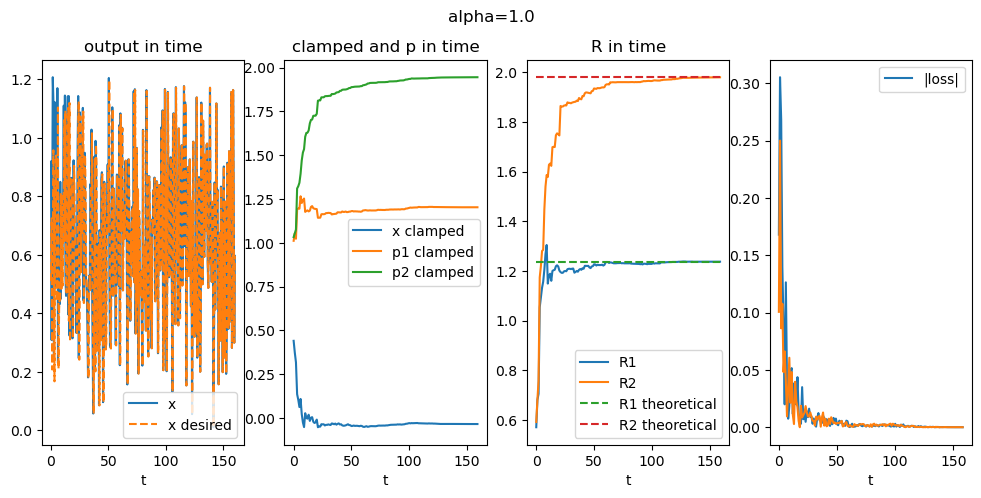

In [5]:
# Training + plot

state, variabs, desired = run_model_changing_alpha(alpha_vec, task_type, training, supress=False, bc_noise=0.0)

Text(0, 0.5, '$x,y$')

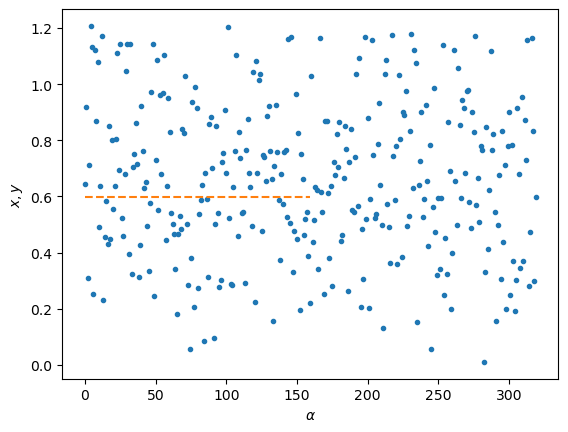

In [6]:
## plot the hysteresis curve
# it will work only if alpha is the same size as t

if len(alpha_vec.T) == len(state.out_in_t):
    plt.plot(alpha_vec.T, state.out_in_t, '.')
    plt.plot(np.outer(desired,np.ones(state.t)).T, '--')
    plt.xlim([min(alpha_vec[0])-0.01, max(alpha_vec[0]+0.01)])
else:
    plt.plot(state.out_in_t, '.')
    plt.plot(np.outer(desired,np.ones(state.t)).T, '--')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$x,y$")